# Inverse problem for the diffusion equation


## Problem setup

We will solve an inverse problem for the diffusion equation with an unknown parameter $C$ :

$$
\frac{\partial y}{\partial t}=C \frac{\partial^2 y}{\partial x^2}-e^{-t}\left(\sin (\pi x)-\pi^2 \sin (\pi x)\right), \quad x \in[-1,1], \quad t \in[0,1]
$$

with the initial condition

$$
y(x, 0)=\sin (\pi x)
$$

and the Dirichlet boundary condition

$$
y(-1, t)=y(1, t)=0
$$


The reference solution is $y=e^{-t} \sin (\pi x)$.


## Dimensional Analysis


Below is the dimensional analysis of the given **diffusion equation** with an unknown parameter $C$:


### Step 1: Assign Dimensions to Variables

1. **Spatial Coordinate $x$:**  
   - Spatial coordinate has the dimension of length:  

     $$
     [x] = L.
     $$

2. **Time $t$:**  
   - Time has the dimension:  

     $$
     [t] = T.
     $$

3. **Function $y(x, t)$:**  
   - $y$ is the solution of the diffusion equation and depends on the context. For this case, $y$ has no explicit physical quantity associated with it, but we assume it to be **dimensionless** since the reference solution is given as $ y = e^{-t} \sin(\pi x) $, where both $e^{-t}$ and $\sin(\pi x)$ are dimensionless.  

     $$
     [y] = 1 \quad \text{(dimensionless)}.
     $$

4. **Parameter $C$:**  
   - The term $C \frac{\partial^2 y}{\partial x^2}$ must have the same dimension as $\frac{\partial y}{\partial t}$ for consistency.  

     - First, consider the time derivative:

       $$
       \left[\frac{\partial y}{\partial t}\right] = \frac{[y]}{[t]} = \frac{1}{T}.
       $$

     - Next, consider the second spatial derivative:  

       $$
       \left[\frac{\partial^2 y}{\partial x^2}\right] = \frac{[y]}{[x]^2} = \frac{1}{L^2}.
       $$
     - Multiplying by $C$, the dimensions of $C$ must satisfy:  

       $$
       [C] \cdot \frac{1}{L^2} = \frac{1}{T} \implies [C] = \frac{L^2}{T}.
       $$

5. **Source Term:** $e^{-t} \left(\sin(\pi x) - \pi^2 \sin(\pi x)\right)$
   - The exponential term $e^{-t}$ and the sine functions are dimensionless. Therefore, the source term is dimensionally consistent with:  
   
     $$
     \text{Source Term} = \frac{1}{T}.
     $$

---

### Step 2: Initial and Boundary Conditions

- **Initial Condition:** $y(x, 0) = \sin(\pi x)$.  
  - $\sin(\pi x)$ is dimensionless, consistent with $ [y] = 1 $.

- **Boundary Condition:** $y(-1, t) = y(1, t) = 0$.  
  - The boundary values are dimensionless.

---

### Step 3: Summary of Dimensions

| Variable/Parameter     | Physical Meaning                   | Dimensions            |
|------------------------|-----------------------------------|-----------------------|
| $x$                  | Spatial coordinate                | $L$                 |
| $t$                  | Time                              | $T$                 |
| $y$                  | Solution (dimensionless)          | $1$                 |
| $C$                  | Diffusion coefficient             | $L^2 / T$           |
| Source term            | Forcing function                  | $1 / T$             |

---

In conclusion,

- The unknown parameter $C$ has dimensions of $L^2 / T$, which is consistent with the physical meaning of a diffusion coefficient.  
- The function $y$ and the boundary/initial conditions are dimensionless, ensuring the consistency of the problem setup.


## Implementation

First, we import the necessary libraries and define the diffusion coefficient $C$.

In [1]:
import brainstate as bst
import brainunit as u

from deepxde import pinnx

Define the physical units for the problem:

In [2]:

unit_of_x = u.meter
unit_of_t = u.second
unit_of_f = 1 / u.second

Define the diffusion coefficient $C$ and the PDE function:

In [3]:
C = bst.ParamState(2.0 * u.meter ** 2 / u.second)


def pde(x, y):
    jacobian = net.jacobian(x, x='t')
    hessian = net.hessian(x, xi='x', xj='x')

    dy_t = jacobian["y"]["t"]
    dy_xx = hessian["y"]["x"]["x"]
    source = (
        u.math.exp(-x['t'] / unit_of_t) *
        (u.math.sin(u.math.pi * x['x'] / unit_of_x) -
         u.math.pi ** 2 * u.math.sin(u.math.pi * x['x'] / unit_of_x))
    )

    return dy_t - C.value * dy_xx + source * unit_of_f


Define the geometry:

In [4]:
geom = pinnx.geometry.Interval(-1, 1)
timedomain = pinnx.geometry.TimeDomain(0, 1)
geomtime = pinnx.geometry.GeometryXTime(geom, timedomain).to_dict_point(x=unit_of_x, t=unit_of_t)


Define the initial and boundary conditions:

In [5]:
def func(x):
    y = u.math.sin(u.math.pi * x['x'] / unit_of_x) * u.math.exp(-x['t'] / unit_of_t)
    return {'y': y}


bc = pinnx.icbc.DirichletBC(func)
ic = pinnx.icbc.IC(func)

Define the observation points:

In [6]:
x = {
    'x': u.math.linspace(-1, 1, num=10) * unit_of_x,
    't': u.math.full((10,), 1) * unit_of_t,
}
observe_y = pinnx.icbc.PointSetBC(x, func(x))

Define the neural network model:

In [7]:
net = pinnx.nn.Model(
    pinnx.nn.DictToArray(x=unit_of_x, t=unit_of_t),
    pinnx.nn.FNN([2] + [32] * 3 + [1], "tanh"),
    pinnx.nn.ArrayToDict(y=None),
)

Define the inverse problem:

In [8]:
problem = pinnx.problem.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    net,
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=x,
    solution=func,
    num_test=10000,
)

Train the neural network model and solve the inverse problem:

Compiling trainer...
'compile' took 0.106258 s

Training trainer...

Step      Train loss                                                   Test loss                                                    Test metric                                       
0         [35.679718 * becquerel2,                                     [45.503433 * becquerel2,                                     [{'y': Array(0.8310661, dtype=float32)}]          
           {'ibc0': {'y': Array(0.7570488, dtype=float32)}},            {'ibc0': {'y': Array(0.7570488, dtype=float32)}},                                                             
           {'ibc1': {'y': Array(0.02982451, dtype=float32)}},           {'ibc1': {'y': Array(0.02982451, dtype=float32)}},                                                            
           {'ibc2': {'y': Array(0.25618497, dtype=float32)}}]           {'ibc2': {'y': Array(0.25618497, dtype=float32)}}]                                                            
0 [2.00e+00 * me

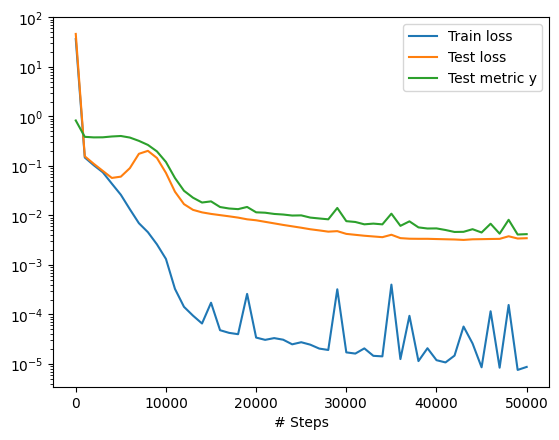

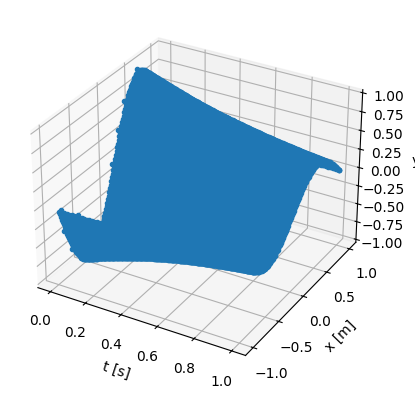

In [9]:
variable = pinnx.callbacks.VariableValue(C, period=1000)
trainer = pinnx.Trainer(problem, external_trainable_variables=C)
trainer.compile(bst.optim.Adam(0.001), metrics=["l2 relative error"]).train(iterations=50000, callbacks=[variable])
trainer.saveplot(issave=True, isplot=True)